# Value-based agent in the cart-pole environment using PyTorch

|        | TYPE             | VALUES | DESCRIPTION                                                                     |
|--------|------------------|--------|---------------------------------------------------------------------------------|
| Action | ndarray<br/>(1,) | {0, 1} | Direction to push cart.<br/>0: left<br/>1: right                                |
| Observation | ndarray<br/>(4,) | float  | 1. Cart position<br/>2. Cart velocity<br/>3. Pole angle<br/>4. Angular velocity |
| Reward |  | float | Reward is given for every step taken, including the termination step.<br/>Each step provides a reward of +1 |
| Termination &<br/>Truncation |  | boolean | Pole Angle exceeds ± 0.2095 rad<br/>Cart Position exceeds ± 2.4 (i.e., edge of the display)<br/>Episode length is greater than 500 |

In [1]:
import sys
import copy
import time
import torch
import gymnasium as gym
import matplotlib.pyplot as plt

from DQN import DeepQ

sys.path.append("../")
from help.visualisation.plot import plot                                                    # noqa
from help.visualisation.gif import gif2                                                     # noqa

In [2]:
environment = gym.make('CartPole-v1', render_mode="rgb_array")

### Training

#### Parameters

In [3]:
GAMES = 4000

GAMMA = 0.99

EXPLORATION_RATE = 1.0
EXPLORATION_DECAY = 0.995
EXPLORATION_MIN = 0.01

MINIBATCH = 64
TRAIN_EVERY = 10

MEMORY = 200
RESET_Q_EVERY = 250

NETWORK = {"inputs": 4, "outputs": 2, "nodes": [15, 30]}
OPTIMIZER = {"optimizer": torch.optim.RMSprop, "lr": 0.0025}

#### Initialisation

In [4]:
value_agent = DeepQ(
    network=NETWORK, optimizer=OPTIMIZER,
    gamma=GAMMA, batch_size=MINIBATCH, memory=MEMORY,
    exploration_rate=EXPLORATION_RATE, exploration_decay=EXPLORATION_DECAY, exploration_min=EXPLORATION_MIN
)

_value_agent = copy.deepcopy(value_agent)

In [5]:
checkpoint = GAMES // 10
metrics = {
    "steps": torch.zeros(GAMES),
    "losses": torch.zeros(GAMES // TRAIN_EVERY),
    "exploration": torch.zeros(GAMES)
}

#### Training

In [6]:
start = time.time()
for game in range(1, GAMES + 1):
    
    state = torch.tensor(environment.reset()[0], dtype=torch.float32).unsqueeze(0)
    terminated = truncated = False
    
    # LEARNING FROM GAME
    # ----------------------------------------------------------------------------------------------
    
    steps = 0
    while not (terminated or truncated):
        steps += 1
        action = value_agent.action(state)
        new_state, reward, terminated, truncated, _ = environment.step(action.item())
        new_state = torch.tensor(new_state, dtype=torch.float32).unsqueeze(0)
        
        value_agent.remember(state, action, new_state, torch.tensor([reward]))
        state = new_state
    value_agent.memorize(steps)
    
    if game % TRAIN_EVERY == 0:
        loss = value_agent.learn(network=_value_agent)
        metrics["losses"][game // TRAIN_EVERY - 1] = loss
    
    if game % RESET_Q_EVERY == 0:
        _value_agent.load_state_dict(value_agent.state_dict())

    # METRICS
    # ----------------------------------------------------------------------------------------------
    
    metrics["steps"][game-1] = steps
    metrics["exploration"][game-1] = value_agent.explore["rate"]
    
    if game % checkpoint == 0 or game == GAMES:
        _mean_steps = metrics["steps"][max(0, game-checkpoint-1):game-1].mean()
        _mean_loss = metrics["losses"][max(0, (game-checkpoint-1) // TRAIN_EVERY):game // TRAIN_EVERY].mean()
        
        print(f"Game {game:>6} {int(game/GAMES * 100):>16} % \n"
              f"{'-'*30} \n"
              f" > Average steps: {int(_mean_steps):>12} \n"
              f" > Average loss: {_mean_loss:>13.4f} \n ")
        
print(f"Total training time: {time.time()-start:.2f} seconds")

Game    400               10 % 
------------------------------ 
 > Average steps:           26 
 > Average loss:        6.7478 
 
Game    800               20 % 
------------------------------ 
 > Average steps:           44 
 > Average loss:        3.2499 
 
Game   1200               30 % 
------------------------------ 
 > Average steps:           93 
 > Average loss:        1.7677 
 
Game   1600               40 % 
------------------------------ 
 > Average steps:          162 
 > Average loss:        0.9499 
 
Game   2000               50 % 
------------------------------ 
 > Average steps:          281 
 > Average loss:        0.5116 
 
Game   2400               60 % 
------------------------------ 
 > Average steps:          373 
 > Average loss:        0.3898 
 
Game   2800               70 % 
------------------------------ 
 > Average steps:          385 
 > Average loss:        0.3366 
 
Game   3200               80 % 
------------------------------ 
 > Average steps:         

#### Visualisation

##### Metrics

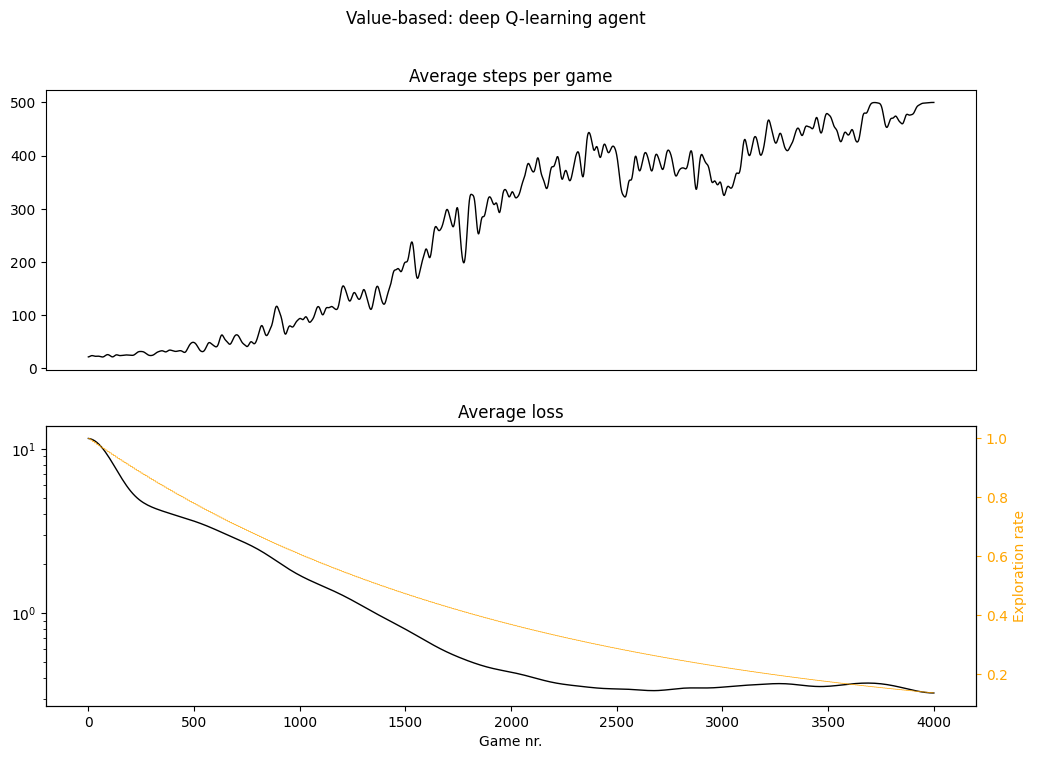

In [7]:
plot(metrics, title="Value-based: deep Q-learning agent", window=10)
plt.savefig("./results/dqn-cart-pole-metrics.png")
plt.show()

##### In action

In [8]:
gif2(environment, value_agent, './results/dqn-cart-pole.gif')

<img src="./results/dqn-cart-pole.gif" width="1000" height="1000" />

In [9]:
environment.close()